In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from src.utils import load, clean_data
from src.preprocessing import DataSet
from src.forecast import TSCV, CLSTM, CLSTMModel
from src.utils import GridSearch
from src.ploting import LinearPlot

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:

CURR = "EURUSD"
INTERVAL = "4h"

eurusd = load(currency=CURR, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_value'])
train, val, test = data.add_variables().clean_data().get_tvt_df()

# Construct LSTM part

In [32]:
from src.forecast.lstm import LSTM_

In [34]:
model = LSTM_(
    activation='tanh',
    target_col='target_value'
)
model.compile()
model.fit(train,
          epochs=10,
          steps_per_epoch=100)

ValueError: Exception encountered when calling layer 'sequential_8' (type Sequential).

Input 0 of layer "lstm_25" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (128, 64)

Call arguments received by layer 'sequential_8' (type Sequential):
  • inputs=tf.Tensor(shape=(128, 10, 49), dtype=float32)
  • training=False
  • mask=None

In [6]:
pred_y = model.predict(test)

48/48 [==============================] - 2s 18ms/step


# Construct CNN part

In [22]:
from src.forecast.cnn import CNN_

In [25]:
model = CNN_(
    activation="selu"
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(train,
          epochs=5,
          steps_per_epoch=100)

KeyError: "None of [Index(['target_direction'], dtype='object')] are in the [index]"

In [518]:
pred = model.predict(test)
res = pd.DataFrame({"pred": pred, "true": test.target_direction[10:]})
res

 1/48 [..............................] - ETA: 13s

2023-05-06 15:24:20.009131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 9ms/step


,pred,true
Datetime,,
2021-11-09 04:00:00,0,0
2021-11-09 08:00:00,0,0
2021-11-09 12:00:00,0,0
2021-11-09 16:00:00,0,0
2021-11-10 00:00:00,0,1
...,...,...
2022-10-17 12:00:00,0,0
2022-10-17 16:00:00,0,0
2022-10-17 20:00:00,0,0


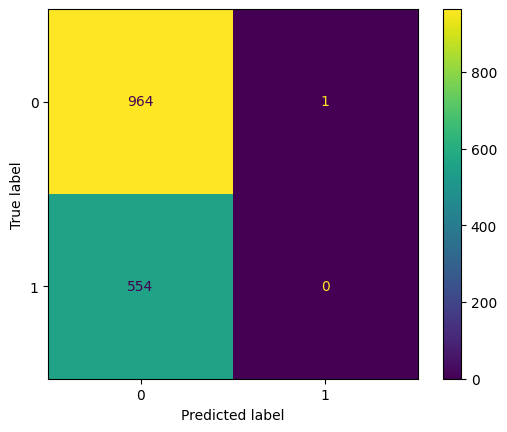

In [519]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(res.true, res.pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()

# Combine both, train and evalute

In [25]:
# model = CLSTMModel(
#     nodes=[64, 32],
#     lstm_nodes=[16, 32, 32, 32],
#     lstm_activation='selu',
#     cnn_filters=4,
#     cnn_kernel_size=4,
#     cnn_activation='selu',
#     activation='selu',
#     seq_len=20
# )
# model.compile()
model.fit(
    data=train,
    epochs=30,
    steps_per_epoch=100,
)

Epoch 1/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6870 - root_mean_squared_error: 0.0157
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.6726 - root_mean_squared_error: 0.0156
New lowest loss: 0.6726
100/100 [==============================] - 7s 68ms/step - loss: 0.6726 - root_mean_squared_error: 0.0156
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.6689 - root_mean_squared_error: 0.0156
New lowest loss: 0.6689
100/100 [==============================] - 7s 68ms/step - loss: 0.6689 - root_mean_squared_error: 0.0156
Epoch 4/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6773 - root_mean_squared_error: 0.0156
Epoch 5/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6832 - root_mean_squared_error: 0.0157
Epoch 6/30
100/100 [==============================] - 7s 71ms/step - loss: 0.6720 - root_mean_squared_error: 0.0156
Epoch 7/30
100/100 [==============================] - 7s

In [36]:
pred_y = model.predict(test)

48/48 [==============================] - 4s 33ms/step


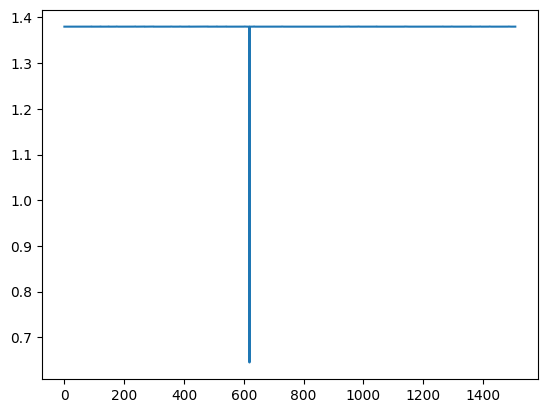

In [37]:
plt.plot(pred_y)

In [39]:
best_mod = CLSTMModel.load(path='best')

In [53]:
best_mod.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

# Timeseries CrossValidation for CLSTM

In [3]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=25,
            test_size=200)

# provide model and all necessary params
tscv.run(CLSTM())

split: 1/25
lstm_kwargs: {'seq_len': 120}
cnn_kwargs: {'seq_len': 120}
[32, 64] tanh
Epoch 1/20
100/100 [==============================] - 11s 75ms/step - loss: 72.8761 - root_mean_squared_error: 0.9300
Epoch 2/20
100/100 [==============================] - 7s 73ms/step - loss: 9.8262 - root_mean_squared_error: 0.1613
Epoch 3/20
100/100 [==============================] - 7s 73ms/step - loss: 7.1662 - root_mean_squared_error: 0.1094
Epoch 4/20
100/100 [==============================] - 7s 74ms/step - loss: 7.0342 - root_mean_squared_error: 0.1074
Epoch 5/20
100/100 [==============================] - 7s 74ms/step - loss: 7.0364 - root_mean_squared_error: 0.1089
Epoch 6/20
100/100 [==============================] - 7s 74ms/step - loss: 6.9334 - root_mean_squared_error: 0.1076
Epoch 7/20
100/100 [==============================] - 7s 72ms/step - loss: 6.9933 - root_mean_squared_error: 0.1085
Epoch 8/20
100/100 [==============================] - 7s 72ms/step - loss: 7.6291 - root_mean_squared

({'mean_absolute_percentage_error': 0.009396962,
  'rmspe': 0.011388208,
  'mean_absolute_error': 0.011170706},
 {'mean_absolute_percentage_error': 0.028165648581144776,
  'rmspe': 0.03536174490829546,
  'mean_absolute_error': 0.03249809428485369})

In [4]:
bestest = CLSTM().load(path="best")

lstm_kwargs: {'seq_len': 120}
cnn_kwargs: {'seq_len': 120}
[32, 64] tanh
Loading model: loss_0.6473.h5..


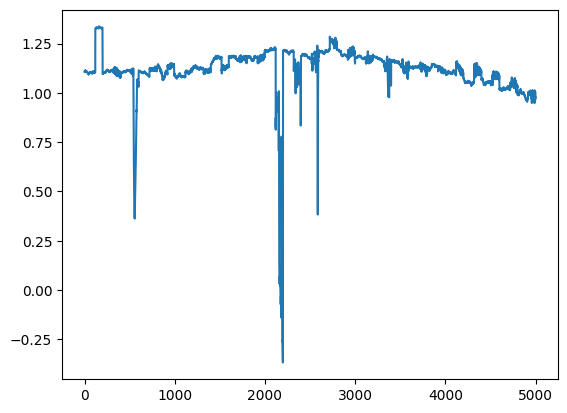

In [5]:
plt.plot(tscv.predicted)

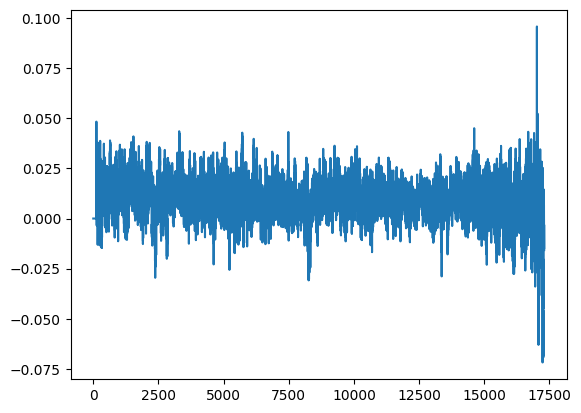

In [6]:
plt.plot(tscv.residuals)

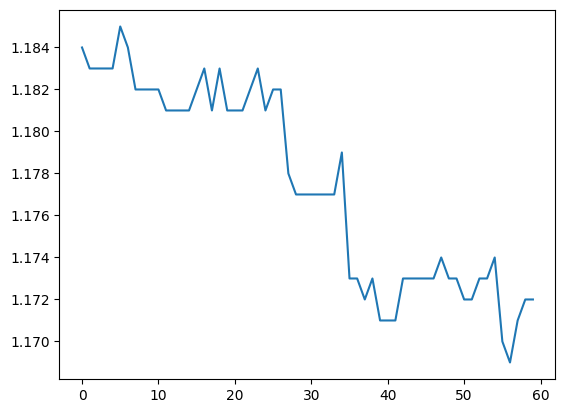

In [7]:
plt.plot(train.Close.values[-60:])

In [12]:
best_mod.summary()

NameError: name 'best_mod' is not defined

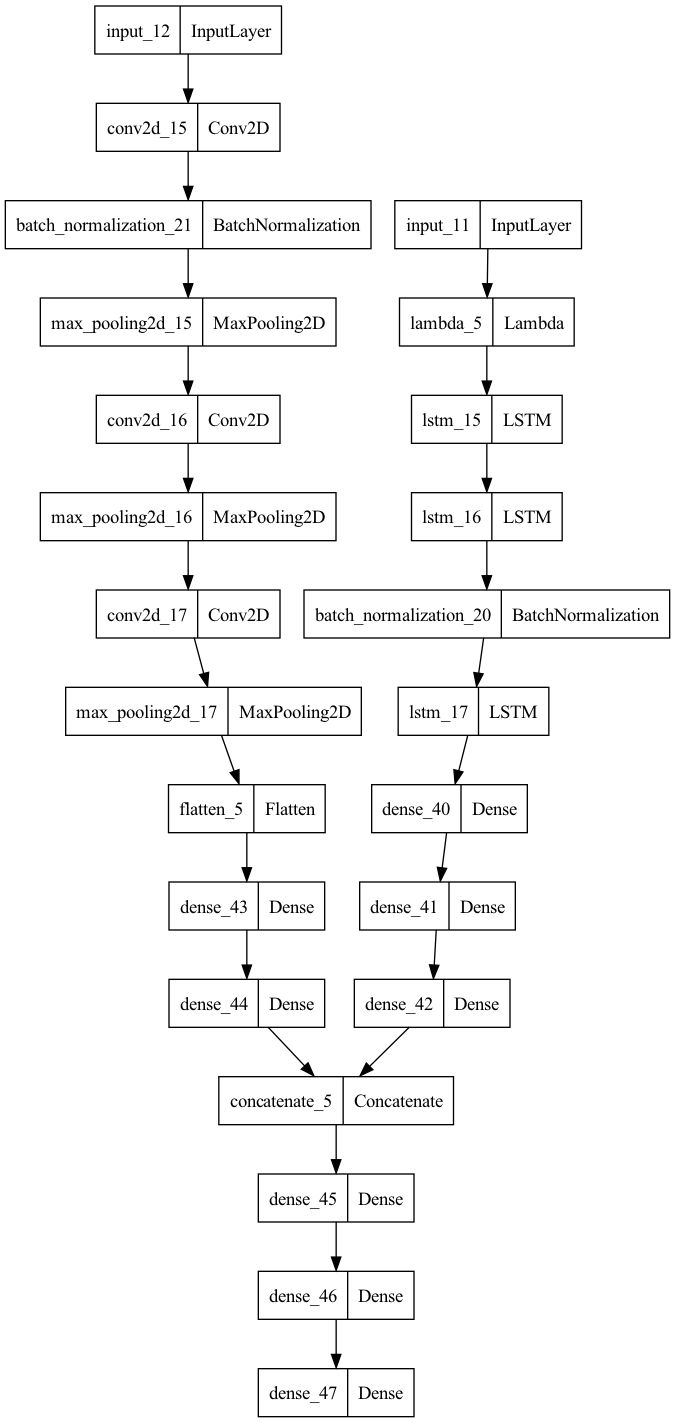

In [20]:
from keras.utils import plot_model
plot_model(bestest.model.model, to_file="best_model.png")

# GridSearch best params

### GridSearch for LSTM part

In [3]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=40)

gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                params={'lstm_activatation': ['selu', 'relu', 'tanh'],
                        'lstm_nodes': [[32, 16, 16, 16],
                                  [64, 32, 32, 32],
                                  [128, 64, 64, 64],
                                  [16, 32, 64, 128]],
                        'seq_len': [30],
                        'epochs': [10]},
                by=['mean_absolute_percentage_error'],
                p_count=None)
gs.run()

split: 1/3
lstm_kwargs: {'activatation': 'selu', 'nodes': [64, 32, 32, 32], 'seq_len': 30}
cnn_kwargs: {'seq_len': 30}
[128, 64] selu
Epoch 1/10
100/100 [==============================] - 11s 73ms/step - loss: 19.5314 - root_mean_squared_error: 0.4068
Epoch 2/10
100/100 [==============================] - 7s 71ms/step - loss: 6.1839 - root_mean_squared_error: 0.0949
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 5.9809 - root_mean_squared_error: 0.0893
Epoch 4/10
100/100 [==============================] - 7s 71ms/step - loss: 5.7845 - root_mean_squared_error: 0.0858
Epoch 5/10
100/100 [==============================] - 7s 71ms/step - loss: 5.2740 - root_mean_squared_error: 0.0779
Epoch 6/10
100/100 [==============================] - 7s 72ms/step - loss: 4.6653 - root_mean_squared_error: 0.0696
Epoch 7/10
100/100 [==============================] - 7s 70ms/step - loss: 4.7510 - root_mean_squared_error: 0.0710
Epoch 8/10
100/100 [==============================] 

### GridSearch for CNN part

In [4]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=40)

gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                params={'cnn_activatation': ['selu', 'relu', 'tanh'],
                        'cnn_filters': [8, 16],
                        'cnn_kernel_size': [8],
                        'cnn_pool_size': [2, 3],
                        'seq_len': [30],
                        'epochs': [10]},
                by=['mean_absolute_percentage_error'],
                p_count=None)

gs.run()

split: 1/3
lstm_kwargs: {'seq_len': 30}
cnn_kwargs: {'activatation': 'selu', 'filters': 8, 'kernel_size': 8, 'pool_size': 2, 'seq_len': 30}
[128, 64] selu
Epoch 1/10
100/100 [==============================] - 12s 86ms/step - loss: 20.7047 - root_mean_squared_error: 0.4005
Epoch 2/10
100/100 [==============================] - 7s 72ms/step - loss: 5.9119 - root_mean_squared_error: 0.0917
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 5.6025 - root_mean_squared_error: 0.0878
Epoch 4/10
100/100 [==============================] - 7s 70ms/step - loss: 4.8767 - root_mean_squared_error: 0.0721
Epoch 5/10
100/100 [==============================] - 7s 70ms/step - loss: 4.4696 - root_mean_squared_error: 0.0668
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 4.1788 - root_mean_squared_error: 0.0625
Epoch 7/10
100/100 [==============================] - 7s 70ms/step - loss: 3.8400 - root_mean_squared_error: 0.0577
Epoch 8/10
100/100 [===========

### GridSearch for following Dense-layers part

In [6]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=40)

gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                # params={'activation': ['tanh', 'selu', 'relu'],
                params={'activation': ['selu', 'relu'],
                        'nodes': [[32, 16],
                                #   [64, 32],
                                  [128, 64],
                                #   [16, 32],
                                  [32, 64]],
                        'seq_len': [120],
                        'epochs': [10]},
                by=['mean_absolute_percentage_error'],
                p_count=None)
gs.run()

split: 1/3
lstm_kwargs: {'seq_len': 120}
cnn_kwargs: {'seq_len': 120}
[32, 16] selu
Epoch 1/10
100/100 [==============================] - 18s 127ms/step - loss: 21.0375 - root_mean_squared_error: 0.3415
Epoch 2/10
100/100 [==============================] - 7s 74ms/step - loss: 6.0097 - root_mean_squared_error: 0.0934
Epoch 3/10
100/100 [==============================] - 8s 75ms/step - loss: 5.8174 - root_mean_squared_error: 0.0909
Epoch 4/10
100/100 [==============================] - 8s 82ms/step - loss: 5.5227 - root_mean_squared_error: 0.0877
Epoch 5/10
100/100 [==============================] - 8s 77ms/step - loss: 5.2844 - root_mean_squared_error: 0.0859
Epoch 6/10
100/100 [==============================] - 8s 77ms/step - loss: 4.9625 - root_mean_squared_error: 0.0808
Epoch 7/10
100/100 [==============================] - 8s 77ms/step - loss: 5.2985 - root_mean_squared_error: 0.0888
Epoch 8/10
100/100 [==============================] - 8s 77ms/step - loss: 5.2649 - root_mean_squared

# Final TSCV of best model

In [12]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=25,
            test_size=200)

clstm = CLSTM().load(path="loss_0.6781_FINAL.h5")
# clstm = CLSTM()
tscv.run(clstm)

lstm_kwargs: {'seq_len': 120}
cnn_kwargs: {'seq_len': 120}
[128, 64] selu
Loading model: loss_0.6781_FINAL.h5..
split: 1/25
3/3 [==============================] - 1s 61ms/step
split: 2/25
3/3 [==============================] - 0s 24ms/step
split: 3/25
3/3 [==============================] - 0s 18ms/step
split: 4/25
3/3 [==============================] - 0s 17ms/step
split: 5/25
3/3 [==============================] - 0s 14ms/step
split: 6/25
3/3 [==============================] - 0s 15ms/step
split: 7/25
3/3 [==============================] - 0s 16ms/step
split: 8/25
3/3 [==============================] - 0s 16ms/step
split: 9/25
3/3 [==============================] - 0s 16ms/step
split: 10/25
3/3 [==============================] - 0s 14ms/step
split: 11/25
3/3 [==============================] - 0s 14ms/step
split: 12/25
3/3 [==============================] - 0s 13ms/step
split: 13/25
3/3 [==============================] - 0s 16ms/step
split: 14/25
3/3 [==============================] - 

({'mean_absolute_percentage_error': 0.0095136585,
  'rmspe': 0.015347227,
  'mean_absolute_error': 0.01099926},
 {'mean_absolute_percentage_error': 0.00801844406030275,
  'rmspe': 0.01592945225365585,
  'mean_absolute_error': 0.00860862185894053})

In [9]:
clstm = CLSTM().load(path="loss_0.6781_FINAL.h5")
train_X, train_y = train.drop(columns=['target_value']), train.target_value
test_X, test_y = test.drop(columns=['target_value']), test.target_value
clstm = tscv.model

pred = clstm.predict(test_X)

lstm_kwargs: {'seq_len': 120}
cnn_kwargs: {'seq_len': 120}
[128, 64] selu
Loading model: loss_0.6781_FINAL.h5..
45/45 [==============================] - 1s 15ms/step


In [20]:
test_y = tscv.dataset.data.target_value.iloc[-5000:]

In [25]:
test_y.shape

(5000,)

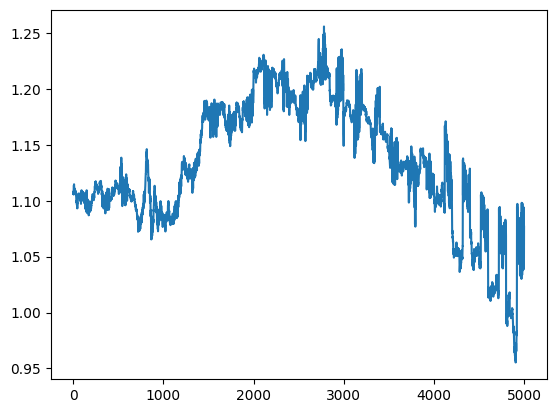

In [21]:
pred = tscv.predicted
plt.plot(pred)

saving: CLSTM
saving: CLSTM


<Axes: title={'center': 'CLSTM'}>

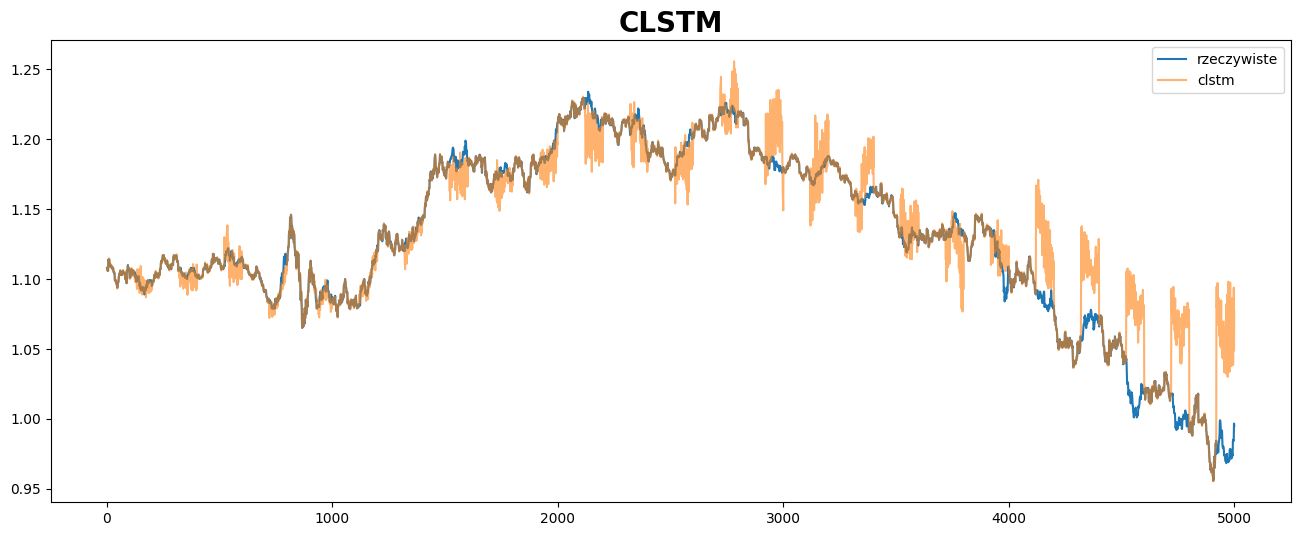

In [26]:

x = train_y.index[-len(pred):]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(range(len(pred)), test_y, label="rzeczywiste", title="CLSTM")
lp.plot(range(len(pred)), pred, label="clstm", alpha=0.6)